# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import mlflow

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Méthodes

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [4]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [5]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [7]:
def clean_text(X):
    X = X.split()
    X_wo_arobas = [x for x in X if not x.startswith("@")]
    X_new = [x for x in X_wo_arobas if not x.startswith("http")]
    return ' '.join(X_new)

In [8]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():        
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        temp_res = tokenize.word_tokenize(temp_res)
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
            # lemmatizer = WordNetLemmatizer()
            # temp_res = [lemmatizer.lemmatize(elt) for elt in temp_res]
        else:
            print("stem or lemma only")
        
        result.append(temp_res)
    return result

In [9]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [10]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [11]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Méthodes pour BOW and Word Embedding

In [12]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [13]:
def representation_by_word2vec(simplified_documents):
    """Compute corpus into a Word2vec vectorisation
    
    Parameters:
    simplified_documents (list(list(str)): a list of documents
    
    Returns:
    the model trained
    """
    model_W2V = Word2Vec(sentences=simplified_documents, vector_size=100, window=5, min_count=300, workers=4)
    model_W2V.train(simplified_documents, total_examples=len(simplified_documents), epochs=50)
    return model_W2V

In [14]:
def display_tsne_plot(model):
    """Display a t-SNE plot from Word Embedding transformation
    
    Parameters:
    model : the Word2vec model trained
    
    Returns:
    
    """
    word_labels = []
    tokens = np.empty((0,100), dtype='f')

    for wrd_score in model.wv.key_to_index:
        wrd_vector = model.wv[wrd_score]
        word_labels.append(wrd_score)
        tokens = np.append(tokens, np.array([wrd_vector]), axis=0)

    tsne_model = TSNE(perplexity=tokens.shape[0]-1, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(word_labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Méthodes pour la matrice de confusion

In [15]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics.confusion_matrix(actual_class, predict_class)#, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    displ = metrics.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [16]:
def display_classification_report(actual_class, predict_class, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(actual_class, predict_class, target_names=display_labels)
    print(clf_report)

# Preparing dataset

In [17]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", sep=',',
                   encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [18]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


,%,%_cumul
label,,
0,50.0,50.0
4,50.0,100.0


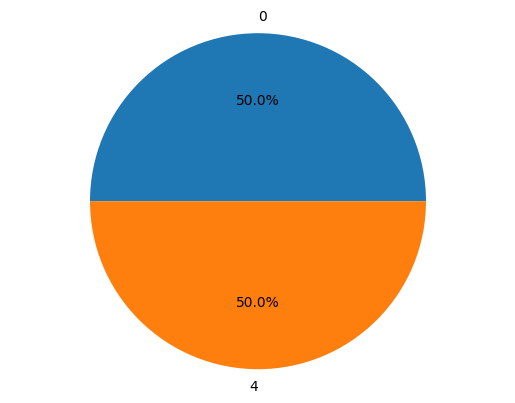

,%,%_cumul
label,,
0,50.0,50.0


In [19]:
show_unique_values(data, "target")

Sentiment du tweet 0 pour négatif et 4 pour positif  
Dans tous les cas, nous n'avons besoin que du texte du tweet et de la target

In [20]:
data.drop(columns=["id", "date", "flag", "user"], inplace=True)

In [21]:
print("The dataset is containing", data.shape[0], "lines and", data.shape[1], "columns.")

The dataset is containing 1600000 lines and 2 columns.


On commence par prendre un échantillon des données dans un premier temps : 10 000 de chaque target.

In [22]:
data_words = data.groupby(['target']).apply(pd.DataFrame.sample, n=10000, replace=True, random_state=42).reset_index(drop=True)

In [23]:
print("The sample dataset is containing", data_words.shape[0], "lines and", data_words.shape[1], "columns.")

The sample dataset is containing 20000 lines and 2 columns.


# Preprocessing

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

2023-06-30 12:12:18.832345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 12:12:18.893652: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 12:12:18.895532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-30 12:12:18.895540: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [25]:
stopW = stopwords.words('english')
stopW.extend(string.punctuation)

In [26]:
# Download SpaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

In [27]:
# Define tokenizer
tokenizer = lambda text: [  # SpaCy Lemmatizer
    token.lemma_.lower() for token in nlp(text) if token.is_alpha and not token.is_stop
]

In [28]:
data_words["text"] = data_words["text"].apply(clean_text)

In [29]:
truc = bidule

NameError: name 'bidule' is not defined

In [ ]:
def preprocess_vectorization(method="tfidf"):
    if method == "tfidf":
        vectorizer = TfidfVectorizer(strip_accents="unicode", lowercase=True,
                                     stop_words=stopW, tokenizer=tokenizer
                                    )

        X = vectorizer.fit_transform(data_words.text)
        vocabulary = vectorizer.get_feature_names_out()
    

### Tf-Idf

In [ ]:
vectorizer = TfidfVectorizer(strip_accents="unicode", lowercase=True,
                             stop_words=stopW, tokenizer=tokenizer
                            )

X = vectorizer.fit_transform(data_words.text)
vocabulary = vectorizer.get_feature_names_out()

### Word2vec

In [30]:
X = data_words.text.apply(tokenizer)

In [31]:
# Tag documents for training
X = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]

# Train doc2vec model
doc2vec = Doc2Vec()
doc2vec.build_vocab(X)
doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# Vectorize text
X = [doc2vec.infer_vector(doc.words) for doc in X]

### Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lsa,
    data_words.target,
    test_size=0.2,
    stratify=data_words.target,
    random_state=42,
)

In [ ]:
model = LogisticRegressionCV(random_state=42)
model.fit(X_train, y_train)

In [ ]:
truc = bidule

In [ ]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    df[col] = df[col].apply(clean_text)
    
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    # if debug:
    #     display(df[[col, 'preproc_text']].head())
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    # if debug:
    #     display(df[[col, 'preproc_text', 'filtpos_text']].head())
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    # print(word_counts)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

In [ ]:
# ponctuation restante dans le top 10
# words_to_exclude = [
#     "``", "''", ".", "..", "...", "....", "....."
# ]
# # mots à supprimer
# words_to_exclude += [
#     "get", "like", "go", "come", "take", "try", "told", "look", "another", "way",
#     "restaurant", "thing", "wife", "husband", "u", "meal", "friend", "eat"
# ]
# tags_to_remove=["JJ", "RB", "MD", "POS", "CD", ":", "PRP", "VBP"]

# corpus = natural_language_processing(
#     data_words, "text", stem_or_lemma="lemma", words_to_exclude=words_to_exclude,
#     tags_to_remove=tags_to_remove, max_threshold=1000, min_threshold=200, debug=False)


corpus = natural_language_processing(data_words, "text", stem_or_lemma="lemma", debug=False, word_cloud=False)

In [ ]:
tfidf_mat, features_names = representation_by_tf_idf(corpus)

In [ ]:
# préparation des données pour l'optimisation
documents = data_words["filtexcl_words"].tolist()
simplified_documents = []
for doc in documents:
    simplified_documents.append([x for x in doc if x in corpus])
dictionary = Dictionary(simplified_documents)
corpus_gensim = [dictionary.doc2bow(doc) for doc in simplified_documents]    

In [ ]:
model_W2V = representation_by_word2vec(simplified_documents)

# Detect topics

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Train LSA model
n_components = 50
lsa = TruncatedSVD(n_components=n_components, random_state=42).fit(tfidf_mat)

In [ ]:
# Plot explained variance ratio of LSA
fig = px.line(
    x=range(1, n_components + 1),
    y=lsa.explained_variance_ratio_,
    title="Explained variance ratio of LSA",
    labels={"x": "Component", "y": "Explained variance ratio"},
    markers=True,
)
fig.show()

Elbow method 5 topics semble t il

In [ ]:
lsa = TruncatedSVD(n_components=5, random_state=42).fit(tfidf_mat)

In [ ]:
X_lsa = lsa.transform(tfidf_mat)
X_lsa.shape

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
plot_top_words(lsa, features_names, 10, "Topics in NMF model (Frobenius norm)")

# Train model logistic regression

In [ ]:
def representation_by_tf_idf_bis(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [ ]:
tfidf_mat, features_names = representation_by_tf_idf_bis(data_words.text)

In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_mat,
    data_words.target,
    test_size=0.2,
    stratify=data_words.target,
    random_state=42,
)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Define model
model = LogisticRegressionCV(random_state=42)

# Train model
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics

In [ ]:
data_words.shape

In [ ]:
display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"])

In [ ]:
display_classification_report(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"])

In [ ]:
def plot_roc_curve(model_name, y_test, y_test_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics.roc_curve(y_test, y_test_pred)#, pos_label=1)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [ ]:
plot_roc_curve("my model", y_test, y_pred)